In [66]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

In [67]:
df = spark.read.csv('data/transformed.csv',inferSchema=True)

In [68]:
# Optionally, rename columns for better clarity
df = df.withColumnRenamed("_c0", "budget") \
       .withColumnRenamed("_c1", "popularity") \
       .withColumnRenamed("_c2", "revenue") \
       .withColumnRenamed("_c3", "runtime") \
       .withColumnRenamed("_c4", "vote_count") \
       .withColumnRenamed("_c5", "genre") \
       .withColumnRenamed("_c6", "release_date") \
       .withColumnRenamed("_c7", "production_country")\
       .withColumnRenamed("_c8", "popularity_rank")\
       .withColumnRenamed("_c9", "risk")
# Let's get an idea of what the data looks like. 
df.printSchema()
df.show()

root
 |-- budget: integer (nullable = true)
 |-- popularity: double (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- production_country: string (nullable = true)
 |-- popularity_rank: string (nullable = true)
 |-- risk: string (nullable = true)

+---------+----------+----------+-------+----------+---------------+------------+------------------+---------------+----+
|   budget|popularity|   revenue|runtime|vote_count|          genre|release_date|production_country|popularity_rank|risk|
+---------+----------+----------+-------+----------+---------------+------------+------------------+---------------+----+
|300000000|139.082615| 961000000|    169|      4500|         Action|  2007-05-19|      united_state|           high| low|
|245000000|107.376788| 880674609|    148|      4466|         Action|  2015-10-26|       

In [69]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Convert categorical columns into numerical representations
indexer_genre = StringIndexer(inputCol="genre", outputCol="genre_index")
indexer_country = StringIndexer(inputCol="production_country", outputCol="country_index")
indexer_risk = StringIndexer(inputCol="risk", outputCol="risk_index")
indexer_rank = StringIndexer(inputCol="popularity_rank", outputCol="rank_index")

# Apply StringIndexer transformations
df = indexer_genre.fit(df).transform(df)
df = indexer_country.fit(df).transform(df)
df = indexer_risk.fit(df).transform(df)
df = indexer_rank.fit(df).transform(df)

In [70]:
from pyspark.sql.functions import col, when, lit

# Get unique genre numbers
unique_genre_numbers = df.select("genre_index").distinct().count()

# Iterate over each unique genre number and create a new column with 1 for true and 0 for false
for i in range(1, unique_genre_numbers + 1):
    genre_col = f"genre_{i}"
    df = df.withColumn(genre_col, when(col("genre_index") == i, lit(1)).otherwise(lit(0)))

# Show the DataFrame with encoded genres
df.show()

+---------+----------+----------+-------+----------+---------------+------------+------------------+---------------+----+-----------+-------------+----------+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|   budget|popularity|   revenue|runtime|vote_count|          genre|release_date|production_country|popularity_rank|risk|genre_index|country_index|risk_index|rank_index|genre_1|genre_2|genre_3|genre_4|genre_5|genre_6|genre_7|genre_8|genre_9|genre_10|genre_11|
+---------+----------+----------+-------+----------+---------------+------------+------------------+---------------+----+-----------+-------------+----------+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|300000000|139.082615| 961000000|    169|      4500|         Action|  2007-05-19|      united_state|           high| low|        1.0|          0.0|       0.0|       0.0|      1|      0|      0|      0|      0|      0|   

Coefficients:
genre_1: 1.03807703738374
genre_2: -0.7130060695987743
genre_3: -0.7081646378644201
genre_4: -0.6915594630139844
genre_5: 2.773407722453191
genre_6: 2.7143601796331693
genre_7: 1.6794211714579006
genre_8: -0.6839190719974491
genre_9: 6.337595063030159
genre_10: 5.0067531226604025
genre_11: 0.0
Intercept: -5.6738976331420075
Objective history:
0.05687775017845671
0.053589835323955164
0.047359551941120966
0.04376891728824981
0.04301420637614041
0.0416183874087713
0.04156216661557973
0.04105248855634139
0.040838917068981524
0.04037594148328003
0.03961687522098299
Area Under ROC: 0.8995736808236808
+--------------------+------+
|                 FPR|   TPR|
+--------------------+------+
|                 0.0|   0.0|
|6.435006435006435E-4|0.1875|
|0.001287001287001287|  0.25|
| 0.04568854568854569|   0.5|
| 0.08687258687258688|0.6875|
| 0.12676962676962678|  0.75|
|  0.3236808236808237|0.9375|
|  0.7355212355212355|   1.0|
|  0.7599742599742599|   1.0|
|  0.8056628056628057|  

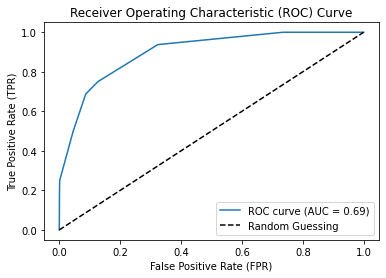

In [87]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

# List of feature column names
all_feature_columns = ['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
data = assembler.transform(df)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=1234)

# Create and train the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="rank_index", maxIter=10)
model = lr.fit(train_data)

# Get model summary
summary = model.summary

# Print the coefficients and intercept of the model
print("Coefficients:")
coefficients = model.coefficients
intercept = model.intercept
for i, feature in enumerate(all_feature_columns):
    print(f"{feature}: {coefficients[i]}")

print(f"Intercept: {intercept}")

# Print the objective history
print("Objective history:")
for objective in summary.objectiveHistory:
    print(objective)

# Print ROC and AUC
print(f"Area Under ROC: {summary.areaUnderROC}")

# Show ROC curve
summary.roc.show()

# Print precision, recall, and F1 score
print("Precision and Recall by threshold:")
for row in summary.pr.collect():
    print(f"Recall: {row['recall']}, Precision: {row['precision']}")

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="rank_index", predictionCol="prediction", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

# Evaluate the model using Area Under ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="rank_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Test Area Under ROC = {auc}")



# Prepare data for ROC curve calculation
predictionAndLabels = predictions.select("prediction", "rank_index").rdd.map(lambda row: (float(row.prediction), float(row.rank_index)))
all_labels = predictionAndLabels.map(lambda x: x[1]).collect()
all_predictions = predictionAndLabels.map(lambda x: x[0]).collect()
thresholds = sorted(list(set(all_predictions)))


summary_data_df = summary.roc.select("FPR")

# Display the DataFrame
summary_data_df.show()

# Collect the data into a Python list
summary_array_FRP = summary_data_df.rdd.map(lambda row: row[0]).collect()


summary_data_df = summary.roc.select("TPR")

# Display the DataFrame
summary_data_df.show()

# Collect the data into a Python list
summary_array_TRP = summary_data_df.rdd.map(lambda row: row[0]).collect()


# Extract thresholds, FPR, and TPR from Precision-Recall data

tpr = summary_array_TRP
fpr = summary_array_FRP

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Stop the Spark session
spark.stop()


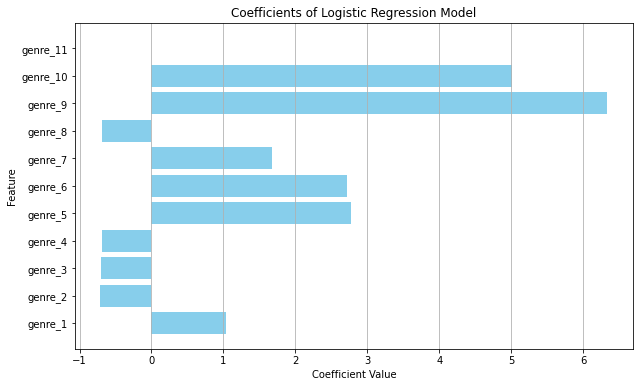

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients and feature names
coefficients = model.coefficients.toArray()
feature_names = all_feature_columns

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Logistic Regression Model')
plt.grid(axis='x')
plt.show()

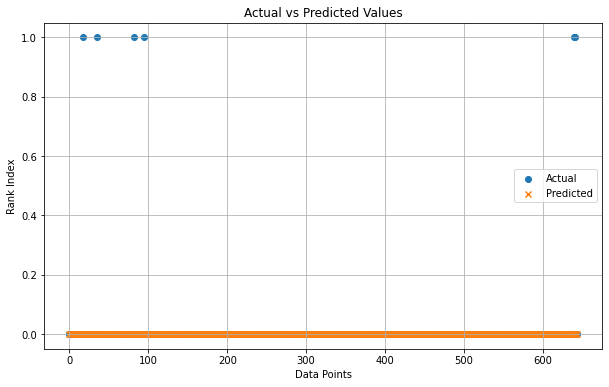

In [39]:
# Collecting the actual and predicted values
actual_values = predictions.select("rank_index").collect()
predicted_values = predictions.select("prediction").collect()

# Extracting the values
actual_values = [float(row.rank_index) for row in actual_values]
predicted_values = [float(row.prediction) for row in predicted_values]

# Plotting the actual vs predicted values as dots
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_values)), actual_values, label='Actual', marker='o')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted', marker='x')
plt.xlabel('Data Points')
plt.ylabel('Rank Index')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# ... (Your previous code to calculate the ROC points)

# Extract FPR and TPR from the ROC points
fpr, tpr = zip(*roc)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Add random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()